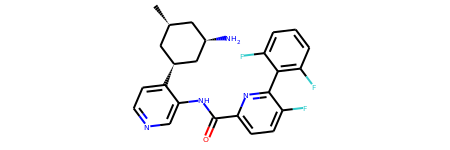

In [1]:
# load dependencies
import os, re
import json
import shutil
import tempfile
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

# if not unique and overwrite, will delete the previous results of the same name!
ligand = "pim447"
job_id = "TL"
job_name = f"RE_{ligand}_{job_id}"

epochs = 20

# --------- change these path variables as required
reinvent_dir = os.path.expanduser("~/repos/Reinvent")
reinvent_env = os.path.expanduser("~/anaconda3/envs/reinvent.v3.2")
output_dir = os.path.expanduser(f"~/.../RE/results/{job_name}")

# --------- do not change
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# if required, generate a folder to store the results
overwrite = False
try:
    os.mkdir(output_dir)
except FileExistsError:
    if overwrite:
        shutil.rmtree(output_dir)
        os.mkdir(output_dir)
    else:
        pass

ligands = {
    "pim447" : Chem.MolFromSmiles("O=C(c1c([H])c([H])c(F)[c@@]([c@@]2c(F)c([H])c([H])c([H])c2F)n1)N(c3c([H])nc([H])c([H])c3[C@@]4([H])C([H])([H])[C@](N([H])[H])([H])C([H])([H])[C@@](C4([H])[H])([H])C([H])([H])[H])[H]"),
    "aha006" : Chem.MolFromSmiles("O=S1(N(Cc2ccccc2)[C@H](COc3ccccc3)[C@H](O)[C@@H](O)[C@@H](COc4ccccc4)N1Cc5ccccc5)=O"),
    "sr3737" : Chem.MolFromSmiles("COc1c(OC)c(OC)cc(NC(c2cccc(n3ncc4c3ccc(Nc5c(F)cccc5)c4)c2)=O)c1"),
    "lre001" : Chem.MolFromSmiles("Nc1nc(N(C2CC2)Cc3sccc3)cc(Cl)n1"),
}
input_model_path = f"{ipynb_path}/models/guacamol.prior"
input_smi_path = f"{output_dir}/{ligand}.smi"
with open(input_smi_path, 'w') as f: f.write(Chem.MolToSmiles(ligands[ligand], canonical=True, kekuleSmiles=False, isomericSmiles=False))
ligands[ligand]

In [2]:
# initialize the dictionary
configuration = {
    "version": 3,                          # we are going to use REINVENT's newest release
    "run_type": "transfer_learning",       # other run types: "scoring", "validation",
                                           #                  "transfer_learning",
                                           #                  "reinforcement_learning" and
                                           #                  "create_model"
    "model_type": "default"
}

In [3]:
# add block to specify whether to run locally or not and
# where to store the results and logging
configuration["logging"] = {
    "sender": "http://127.0.0.1",          # only relevant if "recipient" is set to "remote"
    "recipient": "local",                  # either to local logging or use a remote REST-interface
    "logging_path": os.path.join(output_dir, "progress.log"), # where the run's output is stored
    "job_name": job_name, # set an arbitrary job name for identification
    "job_id": job_id                       # only relevant if "recipient" is set to "remote"
}

In [4]:
adaptive_lr_config = {
      "mode": "constant", # other modes: "exponential", "adaptive", "constant"
      "gamma": 0.8,
      "step": 1,
      "start": 5E-4,
      "min": 1E-5,
      "threshold": 1E-4,
      "average_steps": 4,
      "patience": 8,
      "restart_value": 1E-5,
      "sample_size": 2000,
      "restart_times": 0
    }

In [5]:
output_model_path = os.path.join(output_dir, f"guacamol_{ligand}.agent") \
# The final focused agent will be named "focused.agent"
# The intermediate steps will be named "focused.agent.1", "focused.agent.2", "focused.agent.3" and etc.

# add the "parameters" block
configuration["parameters"] = {
    "input_model_path": input_model_path,
    "output_model_path": output_model_path,             # location to store the focused agent
    "input_smiles_path": input_smi_path,
    "save_every_n_epochs": 1,      # how often to save the focused Agent. Here it's stored after each epoch
    "batch_size": 1,             # batch size the input data
    "num_epochs": epochs,              # number of epochs to focus the agent for
    "standardize": True,           # the input may contain SMILES strings that are invalid according to the agent
                                   # this atempts to clean up the input dataset
    "shuffle_each_epoch": False,   # manual edit to fix cuda bug with torch. Shouldn't matter since n=1.
    "randomize": True,             # this triggers data augmentation which is quite important for small datasets
    "adaptive_lr_config": adaptive_lr_config        # setting the learning rate behavior
    
    
}

In [6]:
# write the configuration file to the disc
configuration_JSON_path = os.path.join(output_dir, "transfer_learning_config.json")
with open(configuration_JSON_path, 'w') as f:
    json.dump(configuration, f, indent=4, sort_keys=True)

## Run `REINVENT`
Now it is time to execute `REINVENT` locally. 

The command-line execution looks like this:
```
# activate envionment
conda activate reinvent.v3.2

# execute REINVENT
python <your_path>/input.py <config>.json
```

In [7]:
%%capture captured_err_stream --no-stderr

# execute REINVENT from the command-line
!{reinvent_env}/bin/python {reinvent_dir}/input.py {configuration_JSON_path}

In [ ]:
# print the output to a file, just to have it for documentation
with open(os.path.join(output_dir, "run.err"), 'w') as file:
    file.write(captured_err_stream.stdout)

## Analyse the results
In order to analyze the run in a more intuitive way, we can use `tensorboard`:

```
# go to the root folder of the output
cd <your_path>/REINVENT_transfer_learning_demo

# make sure, you have activated the proper environment
conda activate reinvent.v3.2

# start tensorboard
tensorboard --logdir progress.log
```
